In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:

# --------------------------------------------------------------------------------
# 1. Вибір та завантаження набору даних: Fashion MNIST
# --------------------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Перетворення інтенсивностей зображень у [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Додаємо вимір каналу (якщо потрібно)
x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

print("Розмір тренувального набору:", x_train.shape)
print("Розмір тестового набору:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Розмір тренувального набору: (60000, 28, 28, 1)
Розмір тестового набору: (10000, 28, 28, 1)


In [3]:

# --------------------------------------------------------------------------------
# 2. Параметри моделі
# --------------------------------------------------------------------------------
latent_dim = 2  # розмір латентного простору (для мінімального прикладу беремо 2)


In [4]:

# --------------------------------------------------------------------------------
# 3. Реалізація блоку вибірки
# --------------------------------------------------------------------------------
class Sampling(layers.Layer):
    """
    Кастомний шар для вибірки точок у латентному просторі
    Використовує параметри (mean та log_var), отримані з енкодера.
    """
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [5]:

# --------------------------------------------------------------------------------
# 4. Створення Енкодера
# --------------------------------------------------------------------------------
# Вхідний шар для зображення розміром 28x28 (канал 1)
encoder_inputs = keras.Input(shape=(28, 28, 1))

# Кілька згорткових шарів (можна і Dense, але Conv часто краще для зображень)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Вихідні шари для середнього (mean) та log_var (logarithm of variance)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Шар вибірки
z = Sampling()([z_mean, z_log_var])

# Створюємо модель енкодера
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# --------------------------------------------------------------------------------
# 5. Створення Декодера
# --------------------------------------------------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,))

# Спочатку відновлюємо активацію до розміру перед Conv2DTranspose
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)

# Зворотні згорткові (Conv2DTranspose) шари для відновлення до 28x28
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:

# --------------------------------------------------------------------------------
# 6. Створення класу VAE (Keras Model)
# --------------------------------------------------------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        """
        Перевизначаємо train_step, щоб додати KL-дивергенцію до реконструктивної втрати.
        """
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Енкодимо
            z_mean, z_log_var, z = self.encoder(data, training=True)
            # Декодимо
            reconstruction = self.decoder(z, training=True)

            # Реконструктивна втрата (binary crossentropy)
            recon_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            recon_loss *= 28 * 28  # масштабуємо до розміру зображення

            # KL-дивергенція
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss) * -0.5

            # Загальна втрата
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Повертаємо метрики
        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }
        
    def test_step(self, data):
        """
        Аналог train_step, але без оновлення ваг. Використовується Keras для валідації.
        """
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)

        # Реконструктивна втрата
        recon_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        recon_loss *= 28 * 28

        # KL-дивергенція
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss) * -0.5

        total_loss = recon_loss + kl_loss

        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)


In [12]:
def dummy_loss(y_true, y_pred):
    # Повертаємо 0, бо вся логіка вже у train_step
    return 0.0


# Створюємо екземпляр VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=dummy_loss)



In [ ]:

# --------------------------------------------------------------------------------
# 7. Навчання моделі
# --------------------------------------------------------------------------------
epochs = 10
batch_size = 128


history = vae.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - kl_loss: 4.6831 - loss: 268.5281 - recon_loss: 263.8449 - val_loss: 0.0000e+00
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - kl_loss: 4.4714 - loss: 266.5587 - recon_loss: 262.0873 - val_loss: 0.0000e+00
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - kl_loss: 4.3841 - loss: 265.3613 - recon_loss: 260.9772 - val_loss: 0.0000e+00
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - kl_loss: 4.3305 - loss: 264.2549 - recon_loss: 259.9244 - val_loss: 0.0000e+00
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - kl_loss: 4.2749 - loss: 263.6306 - recon_loss: 259.3557 - val_loss: 0.0000e+00
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - kl_loss: 4.2316 - loss: 262.7516 - recon_loss: 258.5200 - val_loss: 0.0000e+00
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - kl_loss: 4.1792 - loss: 262.1307 - recon_loss: 257.9515 - val_loss: 0.0000e+00
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step -

Порівняння оригінальних зображень з їх реконструкціями:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


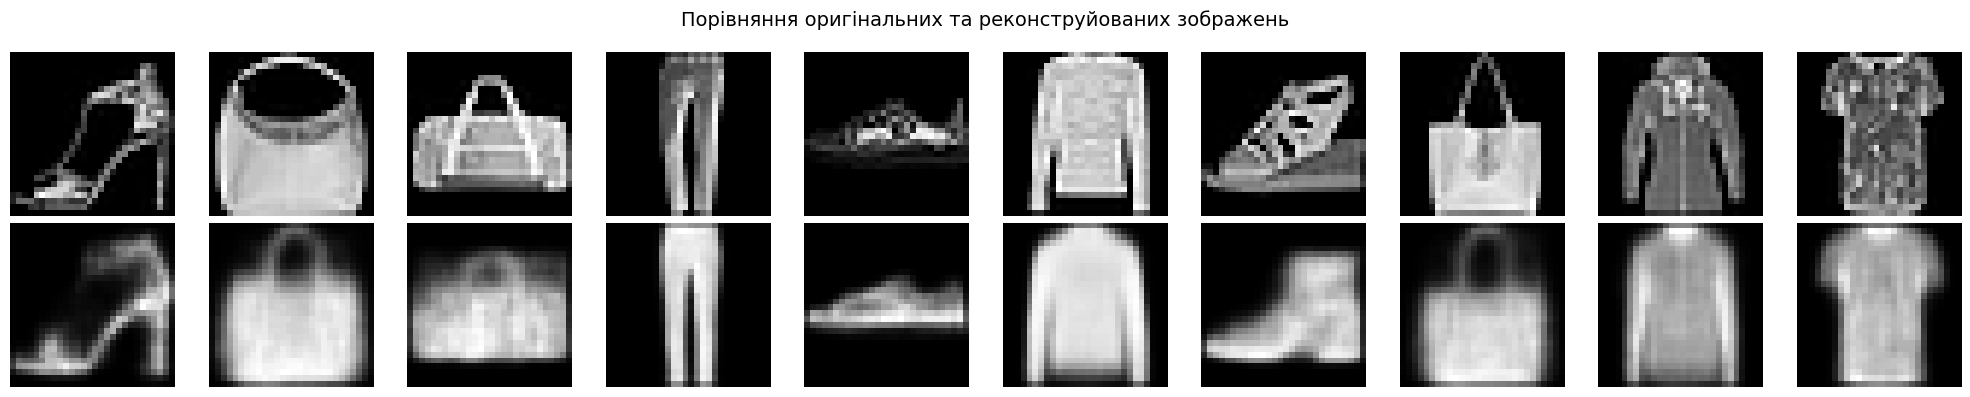


Згенеровані нові зображення:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


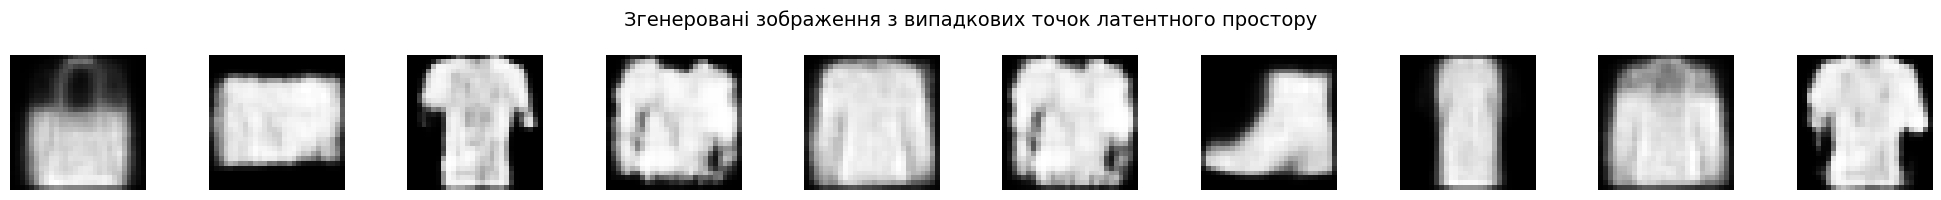

In [16]:
# --------------------------------------------------------------------------------
# 8. Оцінка: реконструйовані та згенеровані зображення
# --------------------------------------------------------------------------------

# (a) Перевірка реконструкції на тестовому наборі
def plot_reconstructions(model, data, n=10):
    """
    Побудова оригінальних та реконструйованих зображень.
    """
    idxs = np.random.randint(0, data.shape[0], size=n)
    original = data[idxs]
    reconstructed = model.predict(original)

    plt.figure(figsize=(2*n, 4))
    plt.suptitle('Порівняння оригінальних та реконструйованих зображень', fontsize=14)
    
    # Оригінальні зображення
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        if i == 0:
            ax.set_ylabel('Оригінал')
        ax.axis("off")

    # Реконструйовані зображення
    for i in range(n):
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        if i == 0:
            ax.set_ylabel('Реконструкція')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Порівняння оригінальних зображень з їх реконструкціями:")
plot_reconstructions(vae, x_test)

# (b) Генерація нових прикладів
def plot_random_generation(decoder, n=10):
    """
    Генерація нових зображень з випадкових точок латентного простору.
    """
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(2*n, 2))
    plt.suptitle('Згенеровані зображення з випадкових точок латентного простору', fontsize=14)
    
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

print("\nЗгенеровані нові зображення:")
plot_random_generation(decoder, n=10)


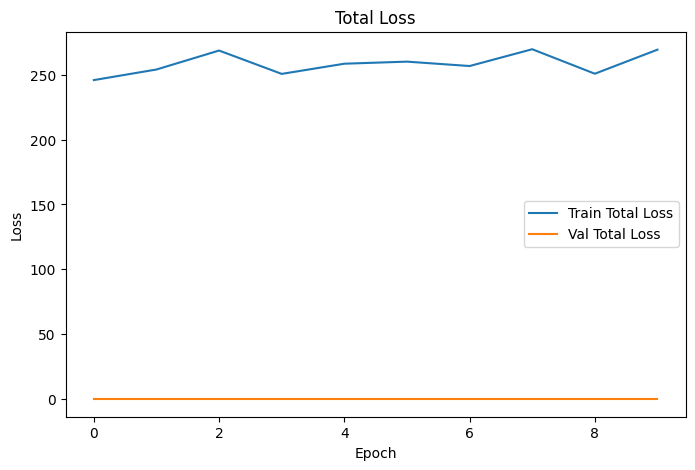

KeyError: 'val_recon_loss'

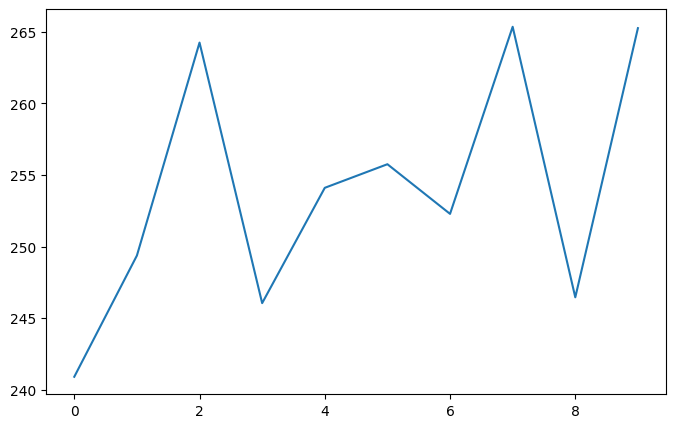

In [17]:
# --------------------------------------------------------------------------------
# 9. Графіки навчання
# --------------------------------------------------------------------------------
# Тепер в history.history зберігаються 6 ключів:
# 'loss', 'recon_loss', 'kl_loss', 'val_loss', 'val_recon_loss', 'val_kl_loss'

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['recon_loss'], label='Train Recon Loss')
plt.plot(history.history['val_recon_loss'], label='Val Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['kl_loss'], label='Train KL Loss')
plt.plot(history.history['val_kl_loss'], label='Val KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('KL Divergence Loss')
plt.legend()
plt.show()

In [ ]:

# --------------------------------------------------------------------------------
# 9. Аналіз результатів
# --------------------------------------------------------------------------------
# - Подивіться, наскільки добре модель відновлює зображення
# - Подивіться на якість згенерованих прикладів
# - Можна додатково порахувати метрики SSIM чи PSNR, але це вже детальніше.
